# Attention is all you Need Vanilla Transformer
The Transformer model is also based on the encoder-decoder architecture. It, however, differs to the seq2seq model that the transformer replaces the recurrent layers in seq2seq with attention layers.

#### Sequence to Sequence vs Transformer
![alt text](./docs/imgs/seq2seq_vs_transformer.png "Title")

#### Multi Head Attention
The most important aspect of this architecture is the usage of the Multi-Head Attention block, this block is used on the Encoder/Decoder and in between:
* Encoder (Input Self-Attention)
* Decoder (Output Self-Attention)
* Between Encoder-Decoder (Same attention as seq2seq)

![alt text](./docs/imgs/IntroTransformer.png "Title")

The difference of the Multi-Head attention is that it allows the same concept to be attented at multiple "h" levels of representation.

#### Positional Encoding
Since the self-attention layer does not distinguish the item order in a sequence, a positional encoding layer is used to add sequential information into each sequence item.


#### References
* [LayerNorm paper](https://arxiv.org/abs/1607.06450)
* [Attention is all you need blog](https://mchromiak.github.io/articles/2017/Sep/12/Transformer-Attention-is-all-you-need/#.XXLlHKeZPys)
* [How to code the transformer in pytorch](https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec)
* [Multiheaded Attention Pytorch Docs](https://pytorch.org/docs/stable/nn.html?highlight=multiheadattention#torch.nn.MultiheadAttention)
* [Transformer from Pytorch Docs](https://pytorch.org/docs/stable/nn.html?highlight=transformer#torch.nn.Transformer)
* [Nice working reference](https://github.com/dreamgonfly/Transformer-pytorch)
* [Notebook compatible with Pytorch 1.0](https://github.com/ArdalanM/annotated-transformer/blob/fix_pytorch_1.0_plus/The%20Annotated%20Transformer.ipynb)
* [Nice Tutorial on Transformers with MxNet](https://www.d2l.ai/chapter_attention-mechanism/transformer.html)

In [1]:
import copy
import math

import torch
from torch import nn
import torch.nn.functional as F
import numpy as np

import utils_transformer as utils

import matplotlib.pyplot as plt
print("PyTorch Version: ",torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
num_gpu = torch.cuda.device_count()
print('Number of GPUs Available:', num_gpu)

PyTorch Version:  1.1.0
Device: cuda:0
Number of GPUs Available: 8


#### HyperParameters

In [2]:
batch_size = 4
sequence_length = 8
hidden_size = 16
attention_heads = 8

#### Attention
In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$.   The keys and values are also packed together into matrices $K$ and $V$.  We compute the matrix of outputs as:                      
                                                                 
$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$   

![alt text](./docs/imgs/attention_block.png "Title")

In [3]:
# Implement attention (Scaled Dot Product)
def attention(query, key, value, dropout=None):
    d_k = query.size(-1)
    key = key.transpose(-2, -1)
    scores = torch.matmul(query, key) / math.sqrt(d_k)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    attention_result = torch.matmul(p_attn, value)
    return attention_result, p_attn

#### MultiHeaded Attention
The MultiHeaded attention block allows us to attend to the same concept at different levels of representation (N)
![alt text](./docs/imgs/multi_head_attention_blk.png "Title")

In [4]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, hidden_size, linears=True, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert hidden_size % h == 0
        # We assume d_v always equals d_k
        self.d_k = hidden_size // h
        self.h = h
        if linears: 
            self.linears = utils.clones(nn.Linear(hidden_size, hidden_size), 4)
        else:
            self.linears = [lambda arg: arg] * 4
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value):
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from hidden_size => h x d_k 
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        
        # Get result from last linear
        x = self.linears[-1](x)
        return x

In [5]:
mha = MultiHeadedAttention(h=attention_heads, hidden_size=hidden_size)
print("With as many attention queries as there are values:\n")
query = torch.tensor(np.ones([batch_size, 1, hidden_size])).float()
value = torch.tensor(np.ones([batch_size, sequence_length, hidden_size])).float()
result = mha.forward(query, value, value)
print("query:", query.size())
print("value:", value.size())
print("result:", result.size())
print("\n")

With as many attention queries as there are values:

query: torch.Size([4, 1, 16])
value: torch.Size([4, 8, 16])
result: torch.Size([4, 1, 16])




#### Position Wise Feed Forward
The idea of this layer is to apply the same FC layer accross different positions(time-steps) on the input, but with different parameters for each layer of the encoder and decoder.

This consists of two linear transformations with a ReLU activation in between.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$                                                                                                                                                                                                      

While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1.  The dimensionality of input and output is $d_{\text{model}}=512$, and the inner-layer has dimensionality $d_{ff}=2048$. 

In [11]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [13]:
ffn = PositionwiseFeedForward(4, 8)
in_test = torch.tensor(np.ones([batch_size, sequence_length, 4])).float()
ffn(in_test)[0]

tensor([[-0.4955,  0.5624,  0.0730,  0.0350],
        [-0.4955,  0.5624,  0.0730,  0.0350],
        [-0.5062,  0.5524,  0.0735,  0.0215],
        [-0.4955,  0.5624,  0.0730,  0.0350],
        [-0.4955,  0.5624,  0.0730,  0.0350],
        [-0.4955,  0.5624,  0.0730,  0.0350],
        [-0.6208,  0.4750,  0.0581, -0.0032],
        [-0.4955,  0.5624,  0.0730,  0.0350]], grad_fn=<SelectBackward>)

#### Positional Encoding

##### register_buffer
This is typically used to register a buffer that should not to be considered a model parameter. For example, BatchNorm’s running_mean is not a parameter, but is part of the persistent state.

In [8]:
# Implements the sinusoidal positional encoding for non-recurrent neural networks.
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        # Few changes to force position/div_term to float
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

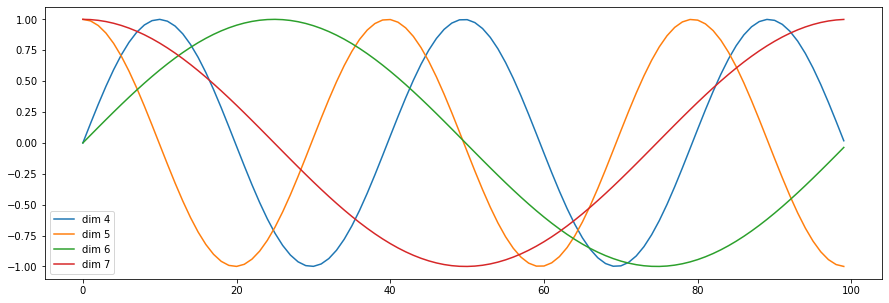

In [9]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None